# Ternary Multiplication in Triton

## Setup

In [1]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


Check the installed triton version.

In [2]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [3]:
import warnings

import torch
import triton.language as tl

## Helper Functions

In [4]:
def get_current_target():
    return triton.runtime.driver.active.get_current_target()

In [5]:
def is_cuda():
    current_target = get_current_target()
    if current_target.backend != "cuda":
        return False

    if current_target.arch < 70:  # CUDA compute capacity is below 7.0, which is minimum 'stable' supported by Triton
        warnings.warn(
            "Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!", stacklevel=1
        )

    return True

## 2D Ternary Multiplication Kernel

First, define the autotune config for the kernel.

In [6]:
def _get_autotune_config_2d():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": 256,
                "BLOCK_SIZE_N": 256,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=5,
            num_warps=2,
        )
    ]

In [7]:
def get_autotune_config_2d():
    if is_cuda():
        return _get_autotune_config_2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

Now we define the Triton kernel. The rough pseudocode algorithm is as follows.
```python
# Do in parallel
for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_N,), dtype=float32)
    for m in range(0, M, BLOCK_SIZE_M):
        x_block = x[m : m+BLOCK_SIZE_M]
        w_block = w[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N]
        
        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elems_to_sum = tl.where(w_block > 0, x_block, tl.where(w_block < 0, -x_block, tl.zeros_like(x_block)))
        acc += tl.sum(elems_to_sum)  # Sum along the M direction

    acc = acc / scale
    z[n : n+BLOCK_SIZE_N] = acc
```

In [8]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_2d(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_2d_kernel(
    # Pointers to arrays
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    M,
    N,
    # The stride variables represent how much to increase the pointer by when moving by 1 element in a particular
    # dimension. E.g. `stride_wm` is how much to increase `w_ptr` by to get the element one row down (the `W` matrix
    # has `M` rows).
    stride_xm,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        z = xW
    `x` has shape `(M,)`, `W` has shape `(M, N)`, and `z` has shape `(N,)`.
    """

    # ----------------------------------------------------------
    # Create pointers for the first blocks of `x` and `W`.
    # We will advance this pointer as we move in the `M` direction and accumulate.
    # - `x_ptrs` is a block of `BLOCK_SIZE_M` pointers
    # - `w_ptrs` is a block of pointers with shape `(BLOCK_SIZE_M, BLOCK_SIZE_N)`
    pid_0 = tl.program_id(axis=0)

    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    x_ptrs = x_ptr + offs_m
    w_ptrs = w_ptr + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks.
    offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_87786/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


Create a convenience wrapper function that handles the checks and kernel calling.

In [9]:
# ruff: noqa: E731, S101, N806
def ternary_mul_2d(x, w, scale):
    # Check constraints
    assert len(x) == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.is_cuda and w.is_cuda

    # Get dimensions
    M, N = w.shape

    # Allocate output
    z = torch.empty((N,), device=x.device, dtype=torch.float32)  # TODO: Change precision?

    # 1D launch kernel where each block gets its own program
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    # fmt: off
    ternary_mul_2d_kernel[grid](
        x, w, z,
        scale,
        M, N,
        x.stride(0),
        w.stride(0), w.stride(1)
    )
    # fmt: on

    return z

Test the kernel.

In [10]:
X_LEN = 256  # x is the 1D vector
W_LEN = 256  # W is the quantized weights matrix
W_SIZE = (X_LEN, W_LEN)

In [11]:
torch.manual_seed(8192)

In [12]:
x = torch.rand(X_LEN, device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SIZE)]
scale = torch.rand(1, dtype=torch.float32).item()

In [13]:
torch_output = torch.matmul(x, w) / scale
print(torch_output)

tensor([-951.4594, -810.9307, -814.1393, -753.9046, -771.3155, -788.1216,
        -772.3747, -750.3213, -766.9465, -775.3512, -796.5271, -740.3124,
        -743.4036, -764.6676, -699.1962, -728.9562, -786.4343, -858.7490,
        -760.0906, -839.8545, -789.4946, -795.4908, -754.4786, -771.1029,
        -783.6049, -834.9073, -931.8519, -694.6861, -695.2032, -707.0848,
        -848.7382, -729.0391, -769.3309, -748.5757, -834.0535, -869.5665,
        -803.8021, -884.6586, -680.9594, -903.9478, -761.8308, -839.1580,
        -803.7127, -718.6333, -751.7179, -751.2381, -769.1642, -787.6885,
        -768.6287, -815.1701, -668.5592, -739.2564, -811.2242, -763.2260,
        -832.9089, -802.8115, -761.8378, -714.6352, -771.6232, -756.2714,
        -863.0844, -838.2726, -721.9910, -765.3901, -799.4003, -860.3110,
        -921.7515, -778.2712, -853.6852, -721.2637, -808.6849, -811.3694,
        -699.9083, -809.1854, -914.3477, -809.1392, -791.8344, -796.9955,
        -751.8312, -731.2245, -900.767

In [14]:
triton_output = ternary_mul_2d(x, w, scale)
print(triton_output)

tensor([-951.4592, -810.9307, -814.1393, -753.9047, -771.3155, -788.1217,
        -772.3747, -750.3212, -766.9465, -775.3511, -796.5271, -740.3126,
        -743.4036, -764.6675, -699.1962, -728.9562, -786.4343, -858.7490,
        -760.0906, -839.8545, -789.4948, -795.4908, -754.4785, -771.1029,
        -783.6047, -834.9072, -931.8519, -694.6860, -695.2033, -707.0848,
        -848.7383, -729.0392, -769.3309, -748.5757, -834.0536, -869.5665,
        -803.8021, -884.6586, -680.9593, -903.9476, -761.8307, -839.1580,
        -803.7127, -718.6334, -751.7179, -751.2381, -769.1642, -787.6886,
        -768.6287, -815.1701, -668.5591, -739.2564, -811.2243, -763.2259,
        -832.9091, -802.8115, -761.8378, -714.6352, -771.6231, -756.2714,
        -863.0844, -838.2726, -721.9910, -765.3901, -799.4003, -860.3109,
        -921.7516, -778.2714, -853.6852, -721.2637, -808.6850, -811.3694,
        -699.9083, -809.1855, -914.3478, -809.1391, -791.8344, -796.9955,
        -751.8312, -731.2245, -900.767

In [15]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


Benchmark the Triton kernel against the standard Torch implementation of matmul.

Trial when M = 128 and N = 128 for cublas
Trial when M = 128 and N = 128 for triton
Trial when M = 256 and N = 256 for cublas
Trial when M = 256 and N = 256 for triton
Trial when M = 384 and N = 384 for cublas
Trial when M = 384 and N = 384 for triton
Trial when M = 512 and N = 512 for cublas
Trial when M = 512 and N = 512 for triton
Trial when M = 640 and N = 640 for cublas
Trial when M = 640 and N = 640 for triton
Trial when M = 768 and N = 768 for cublas
Trial when M = 768 and N = 768 for triton
Trial when M = 896 and N = 896 for cublas
Trial when M = 896 and N = 896 for triton
Trial when M = 1024 and N = 1024 for cublas
Trial when M = 1024 and N = 1024 for triton
Trial when M = 1152 and N = 1152 for cublas
Trial when M = 1152 and N = 1152 for triton
Trial when M = 1280 and N = 1280 for cublas
Trial when M = 1280 and N = 1280 for triton
Trial when M = 1408 and N = 1408 for cublas
Trial when M = 1408 and N = 1408 for triton
Trial when M = 1536 and N = 1536 for cublas
Trial when M = 1

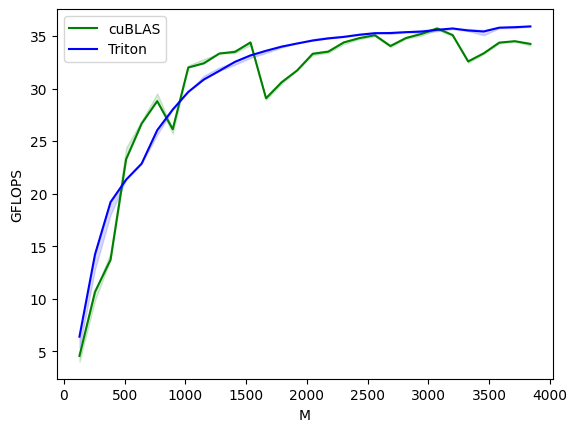

ternary-mul-2d-performance:
         M       N     cuBLAS     Triton
0    128.0   128.0   4.571429   6.400000
1    256.0   256.0  10.666666  14.222222
2    384.0   384.0  13.714286  19.200000
3    512.0   512.0  23.272727  21.333333
4    640.0   640.0  26.666667  22.857142
5    768.0   768.0  28.800001  26.033897
6    896.0   896.0  26.133334  28.000000
7   1024.0  1024.0  32.000000  29.681159
8   1152.0  1152.0  32.400001  30.857143
9   1280.0  1280.0  33.333332  31.683169
10  1408.0  1408.0  33.483044  32.537816
11  1536.0  1536.0  34.388059  33.151080
12  1664.0  1664.0  29.075268  33.590061
13  1792.0  1792.0  30.595121  33.983069
14  1920.0  1920.0  31.718062  34.285715
15  2048.0  2048.0  33.300812  34.565401
16  2176.0  2176.0  33.507246  34.766919
17  2304.0  2304.0  34.384495  34.909092
18  2432.0  2432.0  34.795181  35.112462
19  2560.0  2560.0  35.068492  35.261708
20  2688.0  2688.0  34.045837  35.280001
21  2816.0  2816.0  34.804493  35.360732
22  2944.0  2944.0  35.193348

In [16]:
ref_lib = "cuBLAS"

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 31)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GFLOPS",  # Label name for the y-axis
        plot_name="ternary-mul-2d-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]

@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print(f"Trial when M = {M} and N = {N} for {provider}")
    x = torch.rand(M, device="cuda")
    w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (M, N))]
    scale = torch.rand(1, dtype=torch.float32).item()

    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_2d(x, w, scale), quantiles=quantiles)
    gflops = lambda ms: 2 * M * N * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark.run(show_plots=True, print_data=True)

## 3D Ternary Multiplication Kernel

The autotune config should be similar to the 2D case.

In [17]:
def get_autotune_config_3d():
    if is_cuda():
        return _get_autotune_config_2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [49]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_3d(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_3d_kernel(
    # Pointers to arrays
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    K: tl.constexpr,
    M: tl.constexpr,
    N: tl.constexpr,
    # Strides
    stride_xk,
    stride_xm,
    stride_wk,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the batched ternary multiplication
        z = xW
    `x` has shape `(K, M)`, `W` has shape `(K, M, N)`, and `z` has shape `(K, K, N)`.
    """

    # -----------------------------------------------------------
    # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
    pid_0 = tl.program_id(axis=0)
    pid_1 = tl.program_id(axis=1)

    pid_x = pid_1 % K
    pid_w = pid_1 // K

    # ----------------------------------------------------------
    # Create pointers for the `x` vector and `W` matrix
    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    x_ptrs = x_ptr + pid_x * stride_xk + offs_m
    w_ptrs = w_ptr + pid_w * stride_wk + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
        # perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks
    offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + pid_1 * N + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_87786/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


Create a convenience wrapper function that handles the checks and kernel calling.

In [50]:
# ruff: noqa: E731, S101, N806
def ternary_mul_3d(x, w, scale):
    # Check constraints
    assert w.ndim == 3, "Weight matrix does not have suitable dimensionality"
    assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
    assert x.shape[0] == w.shape[0], "Incompatible batch sizes"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.is_cuda and w.is_cuda

    # Get dimensions
    K, M, N = w.shape

    # Allocate output
    z = torch.zeros((K, K, N), device=x.device)

    # 2D launch kernel
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), K * K)

    # fmt: off
    ternary_mul_3d_kernel[grid](
        x, w, z,
        scale,
        K, M, N,
        x.stride(0), x.stride(1), w.stride(0), w.stride(1), w.stride(2)
    )
    # fmt: on

    return z

In [51]:
X_SHAPE = (3, 5)     # x is the vector
W_SHAPE = (3, 5, 7)  # W is the quantized weights matrix

In [52]:
torch.manual_seed(8192)

In [53]:
x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
scale = torch.rand(1, dtype=torch.float32).item()

In [54]:
torch_output = torch.matmul(x, w) / scale
print(torch_output)

tensor([[[-1.6293, -4.1163, -1.9855, -1.0990, -1.5176, -2.8433, -2.7283],
         [-0.7607, -1.8676, -1.1067, -0.6511, -0.7533, -1.4529, -1.4118],
         [-1.9993, -2.8482, -2.1548, -0.7769, -0.8178, -1.0045, -2.7762]],

        [[-2.2122, -3.3112, -2.5493, -3.0845, -2.9056, -1.8560, -1.1613],
         [-1.1551, -1.8063, -0.8630, -1.7578, -1.2090, -0.8092, -0.4073],
         [-1.5645, -2.3415, -0.7343, -2.9317, -0.8898, -1.4090, -0.6623]],

        [[-3.6483, -4.4726, -3.0173, -2.7283, -1.3880, -0.4679, -4.0046],
         [-1.5142, -2.2136, -1.2164, -1.4118, -0.4558, -0.3534, -1.8602],
         [-1.5112, -3.0038, -2.0713, -2.7762, -0.0720, -1.3370, -1.6668]]],
       device='cuda:0')


In [55]:
triton_output = ternary_mul_3d(x, w, scale)
print(triton_output)

tensor([[[-1.6293, -4.1163, -1.9855, -1.0990, -1.5176, -2.8433, -2.7283],
         [-0.7607, -1.8676, -1.1067, -0.6511, -0.7533, -1.4529, -1.4118],
         [-1.9993, -2.8482, -2.1548, -0.7769, -0.8178, -1.0045, -2.7762]],

        [[-2.2122, -3.3112, -2.5493, -3.0845, -2.9056, -1.8560, -1.1613],
         [-1.1551, -1.8063, -0.8630, -1.7578, -1.2090, -0.8092, -0.4073],
         [-1.5645, -2.3415, -0.7343, -2.9317, -0.8898, -1.4090, -0.6623]],

        [[-3.6483, -4.4726, -3.0173, -2.7283, -1.3880, -0.4679, -4.0046],
         [-1.5142, -2.2136, -1.2164, -1.4118, -0.4558, -0.3534, -1.8602],
         [-1.5112, -3.0038, -2.0713, -2.7762, -0.0720, -1.3370, -1.6668]]],
       device='cuda:0')


In [56]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


Benchmark the Triton kernel against the standard Torch implementation of matmul.

Trial when K = 2, M = 1408, N = 1408, for cublas
Trial when K = 2, M = 1408, N = 1408, for triton
Trial when K = 2, M = 1536, N = 1536, for cublas
Trial when K = 2, M = 1536, N = 1536, for triton
Trial when K = 2, M = 1664, N = 1664, for cublas
Trial when K = 2, M = 1664, N = 1664, for triton
Trial when K = 2, M = 1792, N = 1792, for cublas
Trial when K = 2, M = 1792, N = 1792, for triton
Trial when K = 2, M = 1920, N = 1920, for cublas
Trial when K = 2, M = 1920, N = 1920, for triton


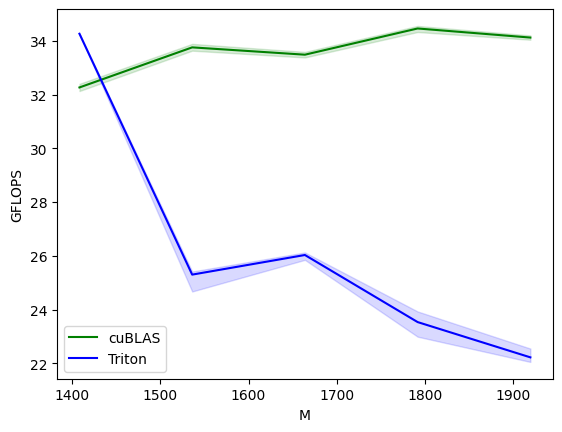

ternary-mul-3d-performance:
        M       N     cuBLAS     Triton
0  1408.0  1408.0  32.266667  34.265486
1  1536.0  1536.0  33.758240  25.301303
2  1664.0  1664.0  33.486070  26.031288
3  1792.0  1792.0  34.461538  23.534710
4  1920.0  1920.0  34.123222  22.222223


In [63]:
ref_lib = "cuBLAS"
K = 4

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(11, 16)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GFLOPS",  # Label name for the y-axis
        plot_name="ternary-mul-3d-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]

@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print(f"Trial when K = {K}, M = {M}, N = {N}, for {provider}")
    x = torch.rand((K, M), device="cuda")
    w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, M, N))]
    scale = torch.rand(1, dtype=torch.float32).item()

    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_3d(x, w, scale), quantiles=quantiles)
    gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark.run(show_plots=True, print_data=True)

## Generalized Ternary Multiplication Kernel (DOES NOT WORK FOR 4D AND ABOVE)

The autotune config should be similar to the 2D case.

In [37]:
# def get_autotune_config():
#     if is_cuda():
#         return _get_autotune_config_2d()
#     else:
#         raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [28]:
# # ruff: noqa: N803, PLR2044
# @triton.autotune(
#     configs=get_autotune_config(),
#     key=["M", "N"],
# )
# @triton.jit
# def ternary_mul_kernel(
#     # Pointers to arrays
#     x_ptr,
#     w_ptr,
#     z_ptr,
#     # Scaling factor
#     scale,
#     # # `W` matrix dimensions
#     M: tl.constexpr,
#     N: tl.constexpr,
#     # Strides
#     matrix_stride,
#     vector_stride,
#     stride_xm,
#     stride_wm,
#     stride_wn,
#     # Counts of matrices and vectors
#     num_stacked_matrices,
#     num_stacked_vectors,
#     # Meta-parameters
#     BLOCK_SIZE_M: tl.constexpr,
#     BLOCK_SIZE_N: tl.constexpr,
# ):
#     """
#     Kernel for computing the ternary multiplication
#         z = xW
#     `x` has shape `(..., M)`, `W` has shape `(..., M, N)`, and `z` has shape `(..., N)`.
#     """

#     # -----------------------------------------------------------
#     # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
#     pid_0 = tl.program_id(axis=0)
#     pid_1 = tl.program_id(axis=1)
    
#     pid_vector = pid_1 % num_stacked_vectors
#     pid_matrix = pid_1 // num_stacked_vectors
    
#     # ----------------------------------------------------------
#     # Create pointers for the `x` vector and `W` matrix
#     offs_m = tl.arange(0, BLOCK_SIZE_M)
#     offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

#     offs_x = pid_vector * vector_stride + offs_m
#     offs_w = pid_matrix * matrix_stride + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)
    
#     x_ptrs = x_ptr + offs_x
#     w_ptrs = w_ptr + offs_w
    
#     # -----------------------------------------------------------
#     # Iterate to compute a block of the `z` vector.
#     # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
#     accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

#     for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
#         # Load the next block of `x` and `W`, generate a mask by checking along `M`.
#         # If it is out of bounds, set it to 0.
#         x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
#         w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

#         # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
#         # perform two conditional checks
#         elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
#         accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

#         # Advance the ptrs to the next `M` block.
#         x_ptrs += BLOCK_SIZE_M * stride_xm
#         w_ptrs += BLOCK_SIZE_M * stride_wm

#     z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

#     # -----------------------------------------------------------
#     # Write back the block of the output vector `z` with masks
#     offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
#     z_ptrs = z_ptr + pid_1 * N + offs_z
#     z_mask = offs_z < N
#     tl.store(z_ptrs, z, mask=z_mask)

Create a convenience wrapper function that handles the checks and kernel calling.

In [29]:
# # ruff: noqa: E731, S101, N806
# def ternary_mul(x, w, scale):
#     # Check constraints
#     assert x.ndim == w.ndim - 1, "Incompatible dimensionality"
#     assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
#     assert x.is_contiguous(), "x must be contiguous"

#     assert x.is_cuda and w.is_cuda

#     # Otherwise, we need to treat what we have as a stack of matrices.
#     # First we get the number of stacked matrices and vectors that we need to process
#     w_shape = w.shape
#     x_shape = x.shape

#     num_stacked_matrices = 1
#     num_stacked_vectors = 1
#     for i in range(w.ndim - 2):  # The last 2 indices are the matrices
#         num_stacked_matrices *= w_shape[i]
#         num_stacked_vectors *= x_shape[i]

#     # Identify the shape of the matrices and vectors that will actually be multiplied
#     matrix_shape = (w_shape[-2], w_shape[-1])
#     matrix_stride = w_shape[-2] * w_shape[-1]
#     vector_stride = x_shape[-1]
    
#     # Get dimensions
#     M, N = w_shape[-2], w_shape[-1]

#     # Determine output size and shape
#     if w.ndim == 2:
#         output_shape = [w_shape[-1]]
#         num_processes = 1  # No need for 2D launch grid
#     else:
#         output_shape = [*list(w_shape[:-2]), x_shape[-2], w_shape[-1]]
#         num_processes = num_stacked_matrices * x_shape[-2]
#     output = torch.zeros(output_shape, device=x.device)
    
#     # 2D launch kernel
#     grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), num_processes)
    
#     # fmt: off
#     ternary_mul_kernel[grid](
#         x, w, output,
#         scale,
#         M, N,
#         matrix_stride, vector_stride, x.stride(-1), w.stride(-2), w.stride(-1),
#         num_stacked_matrices, num_stacked_vectors
#     )
#     # fmt: on

#     return output

Test the kernel.

In [30]:
# # X_SHAPE = (   3, 3, 1)  # x is the vector
# # W_SHAPE = (3, 3, 1, 2)  # W is the quantized weights matrix
# X_SHAPE = (3, 1)  # x is the vector
# W_SHAPE = (3, 1, 2)  # W is the quantized weights matrix

In [31]:
# torch.manual_seed(8192)

In [32]:
# x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
# w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
# scale = torch.rand(1, dtype=torch.float32).item()

In [33]:
# torch_output = torch.matmul(x, w) / scale
# print(torch_output)

In [34]:
# triton_output = ternary_mul(x, w, scale)
# print(triton_output)

In [35]:
# if torch.allclose(triton_output, torch_output, atol=1e-3):
#     print("✅ Triton and Torch match")
# else:
#     raise ValueError("❌ Triton and Torch differ")

In [36]:
# ref_lib = "cuBLAS"
# K = 8

# configs = [
#     triton.testing.Benchmark(
#         x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
#         x_vals=[128 * i for i in range(1, 11)],  # Different possible values for `x_name`
#         line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
#         # Possible values for `line_arg`
#         line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
#         line_names=[ref_lib, "Triton"],  # Line styles
#         styles=[("green", "-"), ("blue", "-")],
#         ylabel="GFLOPS",  # Label name for the y-axis
#         plot_name="ternary-mul-general-performance",  # Name for the plot, used also as a file name for saving the plot.
#         args={},
#     )
# ]

# @triton.testing.perf_report(configs)
# def benchmark(M, N, provider):
#     print(f"Trial when K = {K}, M = {M}, N = {N}, for {provider}")
#     x = torch.rand((K, M), device="cuda")
#     w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, M, N))]
#     scale = torch.rand(1, dtype=torch.float32).item()

#     quantiles = [0.5, 0.2, 0.8]
#     if provider == ref_lib.lower():
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
#     if provider == "triton":
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul(x, w, scale), quantiles=quantiles)
#     gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
#     return gflops(ms), gflops(max_ms), gflops(min_ms)


# benchmark.run(show_plots=True, print_data=True)